In [221]:
from asr import ASR
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mne.io.read_raw_edf??
from numpy import genfromtxt

data_path = os.getcwd()+'/Raw/'
data_file = 'record-[2020.07.02-18.14.02].csv'
mat_fname = os.path.join(data_path, data_file)

data = genfromtxt(mat_fname, delimiter=',')
data = np.nan_to_num(data, copy = False)
#record-[2020.07.02-18.14.02].csv


In [3]:
data

array([[ 0.000000e+00,  0.000000e+00,  4.000000e+00, ...,  1.668852e+06,
         1.668856e+06,  1.668860e+06],
       [ 0.000000e+00,  0.000000e+00,  9.500000e-02, ..., -3.622700e+00,
        -1.007700e+01, -6.430900e+00],
       [ 0.000000e+00,  0.000000e+00,  1.031000e-01, ...,  6.538900e+00,
         3.944500e+00, -6.928300e+00],
       ...,
       [ 0.000000e+00,  0.000000e+00, -1.028000e-01, ...,  1.829500e+00,
        -8.668500e+00,  3.539700e+00],
       [ 0.000000e+00,  0.000000e+00, -2.232000e-01, ...,  3.363600e+00,
        -7.464500e+00, -7.900400e+00],
       [ 0.000000e+00,  0.000000e+00,  4.908000e-01, ..., -5.918400e+00,
        -3.306100e+00,  6.532000e+00]])

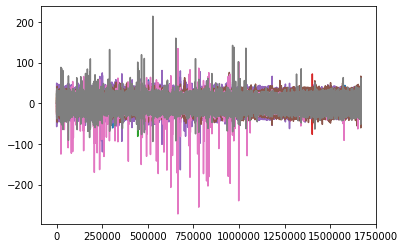

In [4]:
plt.plot(data[0,:],data[1:,:].T);

In [5]:
#LOADING DATA
#---------------
#Get data path and load data

ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
sfreq=250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq,  ch_types='eeg')
raw = mne.io.RawArray(data[1:,:], info)


Creating RawArray with float64 data, n_channels=8, n_times=417217
    Range : 0 ... 417216 =      0.000 ...  1668.864 secs
Ready.


In [6]:
markers = None
try:
    markers = np.load("labels.npy")
except:
    data_file = 'classes.txt'
    mat_fname = os.path.join(data_path, data_file)
    labels = np.genfromtxt(mat_fname,replace_space='', usecols = range(3),  dtype=str)
    data_file = 'markers.mrk'
    mat_fname = os.path.join(data_path, data_file)
    time_point = np.genfromtxt(mat_fname,replace_space='', usecols = range(3),  dtype=str)
    
    markers = np.zeros((30,4))
    markers[:,0] = np.int_(time_point[1::2,0])
    markers[:,1] = np.int_(labels[:,0]=='Calm')
    markers[:,2] = np.int_(labels[:,0]=='Pos')
    markers[:,3] = np.int_(labels[:,0]=='Neg')
    np.save("labels.npy", markers)
finally:
    if markers is None:
        print("download marker file")
    else:
        print("marker success")

marker success


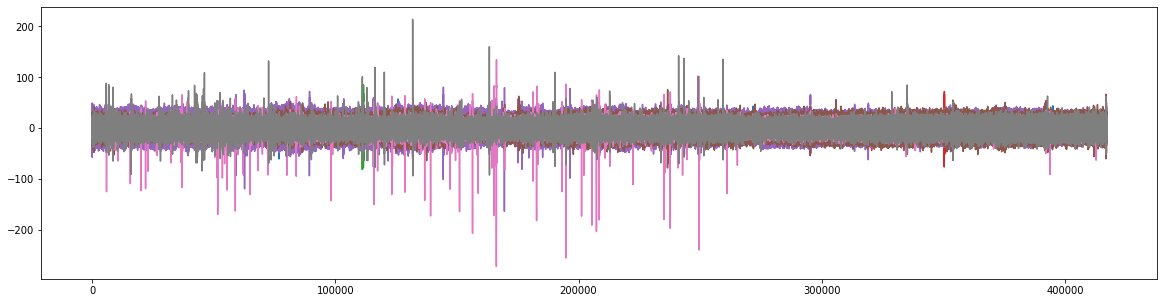

In [7]:
#plot raw data
plt.figure(figsize=(20,5))
plt.plot(raw.get_data().T);

In [8]:
#PREPROCESSING
#---------------

In [9]:
#Seperate calibration and recording
raw_calib = raw.copy()
raw_calib.crop(tmax=60.)
raw.crop(tmin=60.)


<RawArray  |  None, n_channels x n_times : 8 x 402217 (1608.9 sec), ~24.6 MB, data loaded>

In [10]:
#initialize Artifact Subspace Reconstruction
asr = ASR()

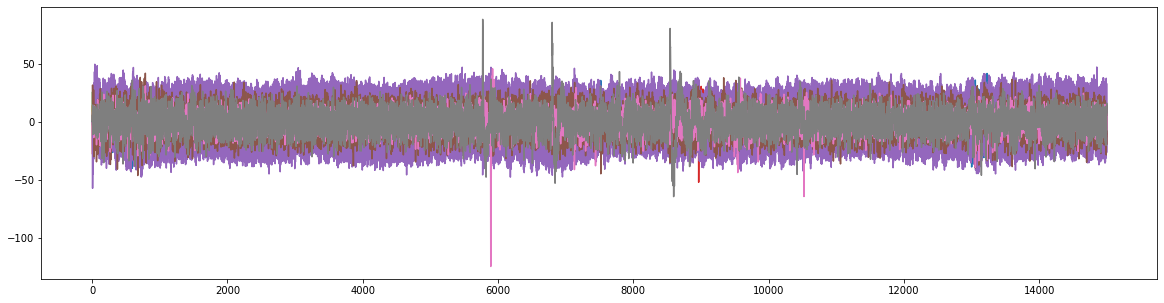

In [11]:
#plot calibration data

x_c = asr.clean_windows(raw_calib)
plt.figure(figsize=(20,5))
plt.plot(x_c.T);


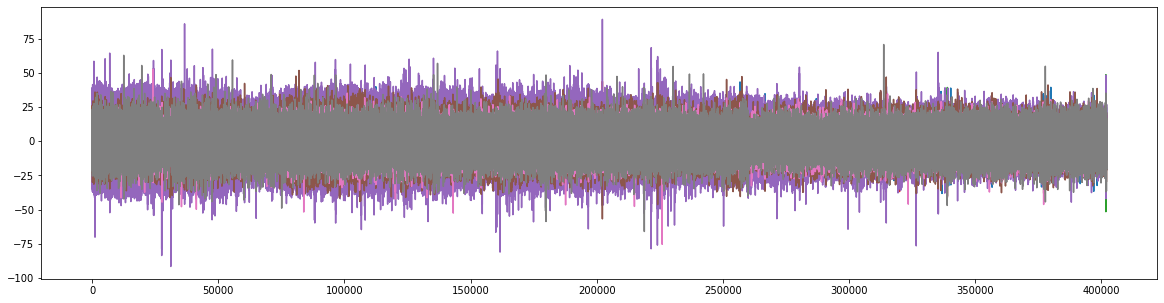

In [12]:
# clean up signal and plot - reconstruct parts with high amplitude noise such as eyeblinks
asr.calibrate(k = 15)
out = asr.clean(raw)
plt.figure(figsize=(20,5))
plt.plot(out.T);

In [13]:
len(raw.times)/(250*80)

20.11085

In [14]:
len(range(0,len(raw.times), 80*250))

21

In [222]:
#FEATURE EXTRACTION
#---------------

#concatenate data of same trials

Meditate = np.empty((8,0))
Stress = np.empty((8,0))



trial_offsets = range(0,len(raw.times), 80*250)
trial_len = 60*250

for i, o in enumerate(trial_offsets):
    if i<10:
        #print(i, o)
        Meditate = np.concatenate((Meditate, raw.get_data()[:, o: o+trial_len]), axis = 1)
    elif i<20:
        #print(i, o)
        Stress = np.concatenate((Stress, raw.get_data()[:, o: o+trial_len]), axis = 1)
    
        
print("amount of data: Meditate " + str(Meditate.shape[1]) + " Pos " + str(Stress.shape[1]))


amount of data: Meditate 150000 Pos 150000


In [223]:
def sliding_window(data, sf, win_len=1, win_overlap=0.66):
    #win_len and win_overlap in s!

    n_samples = data.shape[1]
    win_samples = int(win_len*sf)
    offsets = np.int_(np.arange(0,  n_samples - win_samples, np.round(win_samples * (1 - win_overlap))))

    #append window
    windows=[]
    for o in offsets:
        windows.append(data[:,o:o+win_samples])
                       
    return np.array(windows)

In [224]:
#create trials using sliding window

Med_windows = sliding_window(Meditate, 256)
Stress_windows = sliding_window(Stress, 256)
#Neg_windows = sliding_window(Neg, 256)

In [225]:
#create labels

labels = np.zeros((2, Med_windows.shape[0]+Stress_windows.shape[0]))
labels[0,:Med_windows.shape[0]]=1
labels[1,Med_windows.shape[0]:Med_windows.shape[0]+Stress_windows.shape[0]] =1

In [226]:
#concatenate all data

data = np.concatenate((Med_windows, Stress_windows), axis = 0)


In [227]:
#export data and labels
np.save("data_Eric.npy", data)
np.save("labels_Eric.npy", labels)

In [228]:
#CLASSIFICATION
#---------------


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#extract alpha

alpha = mne.filter.filter_data(data, 256, 5, 12)
#should not do normalizing here!!
#alpha /= alpha.mean(axis=2)[:, :, np.newaxis]
#alpha -= alpha.std(axis=2)[:, :, np.newaxis]

X, y = shuffle(alpha, labels.T)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Setting up band-pass filter from 5 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 423 samples (1.652 sec)



<ipython-input-228-a0d9012eeee2>:10: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  alpha = mne.filter.filter_data(data, 256, 5, 12)


In [229]:
#%pip install pyriemann
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, ShuffleSplit

def train_riemann_ts(X_data, labels):
    # Riemannian Tangent Space Logistic Regression for EEG

    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

    # Define a unique pipeline to sequentially:
    clf = make_pipeline(
        Covariances(estimator='lwf'),
        TangentSpace(),
        LogisticRegression(solver='lbfgs'))

    scores = cross_validate(clf, X_data, labels, cv=cv, n_jobs=1, return_estimator=True, return_train_score=False)

    print('Mean: {0}, Std: {1}'.format(scores['test_score'].mean(), scores['test_score'].std()))

    # best_est = scores['estimator'][scores['test_score'].argmax()]
    best_est = clf.fit(X_data, labels)  # refit the estimator on the whole set

    return best_est, scores, clf

In [230]:
#Chance = 0.5!!
best_est, scores, clf=train_riemann_ts(alpha, np.argmax(labels.T, axis=1))

Mean: 0.7683599419448476, Std: 0.010806682420311338


In [255]:
pred=clf.predict(X_test)
target = y_test

In [274]:
true_pred = np.array(pred == target.argmax(1))

In [275]:
true_pred.shape

(1137,)

In [278]:
sad = []
sad_cov =[]
happy = []
happy_cov = []
tangents = []
for index, (x, tf) in enumerate(zip(X_test, true_pred)):
    if tf:
        covariance=clf[0].transform(X_test[index].reshape(1, X_test.shape[1], X_test.shape[2]))
        tangent = clf[1].transform(covariance)
        if y_test[index].argmax() == 0:
            sad.append(tangent)
            sad_cov.append(covariance.reshape(X_test.shape[1], X_test.shape[1]))
        if y_test[index].argmax() == 1:
            happy.append(tangent)
            happy_cov.append(covariance.reshape(X_test.shape[1], X_test.shape[1]))
        tangents.append(tangent)

In [279]:
sad = np.asarray(sad)
happy = np.asarray(happy)
sad_cov = np.asarray(sad_cov)
happy_cov = np.asarray(happy_cov)

In [280]:
distances = np.zeros((50,50))
from pyriemann.utils.distance import distance_riemann
for i,A in enumerate(sad_cov[:50]):
    for j,B in enumerate(happy_cov[:50]):
        dist = distance_riemann(A,B)
        distances[i,j] = dist

In [281]:
sad_distances = np.zeros((50,50))
for i,A in enumerate(sad_cov[:50]):
    for j,B in enumerate(sad_cov[:50]):
        dist = distance_riemann(A,B)
        sad_distances[i,j] = dist
happy_distances = np.zeros((50,50))
for i,A in enumerate(happy_cov[:50]):
    for j,B in enumerate(happy_cov[:50]):
        dist = distance_riemann(A,B)
        happy_distances[i,j] = dist

In [282]:
np.mean(sad_distances)

3.7912273910056262

In [283]:
np.mean(happy_distances)

3.4312808086564357

In [284]:
np.mean(distances)

4.005527215697046

([array([ 50.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  16.,  28., 118.,
         150., 252., 300., 262., 248., 272., 226., 192., 122.,  72.,  54.,
          38.,  14.,  16.,  10.,  12.,  26.,  10.,  10.]),
  array([ 50.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,  30.,  76., 198.,
         258., 266., 320., 326., 264., 220., 238., 164.,  78.,   6.,   2.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   9.,  31.,
          86., 187., 241., 321., 347., 314., 303., 262., 161.,  90.,  45.,
          26.,  13.,  13.,   8.,  13.,  16.,   6.,   6.])],
 array([1.26584901e-15, 2.44928671e-01, 4.89857342e-01, 7.34786012e-01,
        9.79714683e-01, 1.22464335e+00, 1.46957202e+00, 1.71450070e+00,
        1.95942937e+00, 2.20435804e+00, 2.44928671e+00, 2.69421538e+00,
        2.93914405e+00, 3.18407272e+00, 3.42900139e+00, 3.67393006e+00,
        3.91885873e+00, 4.16378740e+00, 4.40871607e+00, 4.65364475e+00,
        4.89

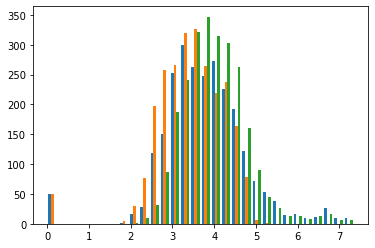

In [285]:
plt.hist([sad_distances.flatten(), happy_distances.flatten(), distances.flatten()], bins=30)

In [286]:
from sklearn.manifold import TSNE
x_sad = TSNE(n_components =2).fit_transform(sad.reshape(sad.shape[0], sad.shape[2]))

In [287]:
x_happy = TSNE(n_components =2).fit_transform(happy.reshape(happy.shape[0],happy.shape[2]))

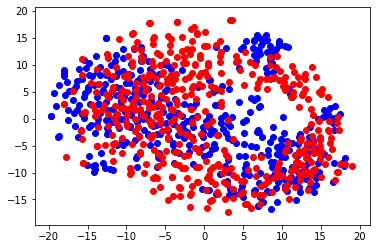

In [288]:
plt.scatter(x_sad[:,0], x_sad[:,1], c='blue')
plt.scatter(x_happy[:,0], x_happy[:,1], c= 'red')

In [289]:
x_sad_cov = TSNE(n_components =2 ).fit_transform(sad_cov.reshape(sad_cov.shape[0], 64))
x_happy_cov = TSNE(n_components =2).fit_transform(happy_cov.reshape(happy_cov.shape[0],64))

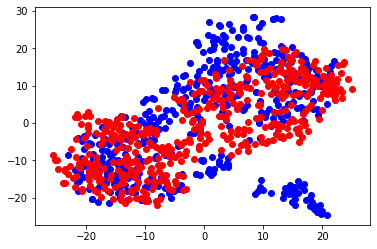

In [290]:
plt.scatter(x_sad_cov[:,0], x_sad_cov[:,1], c='blue')
plt.scatter(x_happy_cov[:,0], x_happy_cov[:,1], c= 'red')

In [291]:
from pyriemann.embedding import Embedding
embedding=Embedding(n_components=2, metric='riemann', eps=None)
x_sad_cov=embedding.fit_transform(sad_cov)

In [292]:
x_happy_cov = embedding.fit_transform(happy_cov)

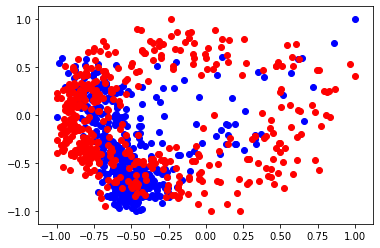

In [293]:
plt.scatter(x_sad_cov[:,0], x_sad_cov[:,1], c='blue')
plt.scatter(x_happy_cov[:,0], x_happy_cov[:,1], c= 'red')